In [107]:
import pandas as pd
import re
from collections import Counter
import numpy as np
import glob
from tqdm import tqdm
from numpy.linalg import norm
import itertools
import matplotlib.pyplot as plt

In [64]:
def preprocess_text(path):
    with open(path, "r") as f:
        text = f.read()
    text = re.sub(r"[.,-;!?–']", "", text)
    text = text.lower().split()
    length = len(text)
    cnt = Counter(text)
    for k,v in cnt.items():
        cnt[k] = v/length
    return cnt
    

def count_words_in_docs(paths):
    counteddocuments = []
    for path in paths:
        cnt = preprocess_text(path)
        counteddocuments.append(cnt)
    return counteddocuments
        

def z_standardization(word, document, counteddocuments):
    
    freqs_across_docs = [doc[word] for doc in counteddocuments]
    
    mue = np.mean(freqs_across_docs)
    sigma = np.std(freqs_across_docs)
    
    z = (document[word] - mue)/sigma
    
    return(z)

def create_doc_term_matrix(paths, n):
    counteddocuments = count_words_in_docs(paths)
    
    #n most frequent words in corpus
    mfw = Counter()
    for cnt in tqdm(counteddocuments, desc='accumulate total'):
        mfw += cnt
    nmfw = [tupel[0] for tupel in mfw.most_common(n)]
    
    
    df = pd.DataFrame(columns=[re.sub(r"\w+\/|\.txt", "", path) for path in paths], index=nmfw)
    
    for path in tqdm(paths, desc='build frequency matrix'):
        cnt = preprocess_text(path)  
        cnt_nmfw = []
        for w in nmfw:
            cnt_nmfw.append(cnt[w])
        df[re.sub(r"\w+\/|\.txt", "", path)] = cnt_nmfw
    
    #z-normalize across docs after building frequency matrix (performance)
    for w in tqdm(nmfw, desc='z-normalize'):
        freqs_across_docs = df.loc[w]
        mu = freqs_across_docs.mean()
        sigma = freqs_across_docs.std()
        df.loc[w] = (freqs_across_docs - mu) / sigma
    return(df)
    
    

In [63]:
paths = glob.glob("gerdracor_txt/*.txt")

In [61]:
df = create_doc_term_matrix(paths, 1000)
df

build matrix: 100%|██████████| 612/612 [00:04<00:00, 126.45it/s]


,sievers-die-schatzgraeber,musil-die-schwaermer,eichendorff-die-freier,gleich-der-eheteufel-auf-reisen,kotzebue-maedchenfreundschaft,schnitzler-reigen,scheerbart-die-lustigen-raeuber,hebbel-genoveva,klinger-die-neue-arria,costenoble-die-katze-laesst-das-mausen-nicht,...,kaltneker-das-bergwerk,hasenclever-der-sohn,wagner-die-reue-nach-der-that,schlegel-jon,ruederer-die-fahnenweihe,raimund-der-alpenkoenig-und-der-menschenfeind,stavenhagen-mudder-mews,moser-krieg-oder-frieden,wedekind-franziska,wedekind-fruehlings-erwachen
ich,0.240543,0.246652,-0.019914,0.484818,-0.249541,1.481922,-1.482402,0.980344,0.897956,-0.379862,...,-0.645689,2.312354,0.446384,-1.047084,-2.017128,0.958248,-3.311506,0.774794,0.940935,1.243024
und,0.277101,-0.481949,-0.127038,-0.438070,-1.401482,-1.514917,0.281011,0.328834,1.896498,0.426088,...,-1.136202,-0.106198,-0.640114,0.795775,-0.737185,-0.312610,-2.395051,-1.393777,-1.498872,-0.533444
die,-1.787203,-1.137751,0.543530,-1.122913,0.022339,-1.125567,3.176269,-0.370615,-0.730584,-0.515218,...,0.108153,0.120949,-0.642397,0.576697,0.239647,-0.040193,-2.886790,-0.722501,0.075656,0.498989
der,-0.498963,-1.295097,0.277457,0.561892,0.170903,-1.464201,-1.012129,0.118115,-0.643708,0.643954,...,-0.412778,-0.714643,-0.746692,0.901463,0.952937,-0.253262,-2.997801,-0.962434,-0.485286,-0.628729
sie,-1.396040,1.083043,0.455950,-0.125709,1.821891,-0.151697,0.780838,0.187814,0.414664,-0.547660,...,-0.212234,-0.175517,1.178680,-0.384557,-0.017266,-0.110037,-1.404971,-0.265781,0.171232,-0.384282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
offen,-0.704441,0.252141,-0.147604,-0.704441,-0.704441,0.357258,3.729643,0.336571,-0.357209,-0.704441,...,-0.704441,0.029409,-0.704441,-0.226716,0.065098,0.559273,-0.704441,1.041524,0.460508,0.643165
hut,-0.499650,-0.499650,1.476711,0.380523,-0.499650,1.384475,-0.499650,-0.499650,0.732767,-0.499650,...,-0.499650,-0.239187,-0.499650,-0.499650,-0.499650,-0.200633,1.727853,0.739728,-0.499650,-0.180782
hülfe,1.148478,-0.515492,-0.515492,-0.515492,2.602666,-0.515492,-0.515492,-0.515492,0.758731,6.530485,...,-0.515492,-0.515492,1.496205,-0.164874,-0.515492,3.503591,-0.515492,-0.515492,-0.515492,-0.515492
thron,-0.373474,-0.373474,-0.373474,-0.373474,-0.373474,-0.373474,-0.373474,-0.096366,-0.188614,0.356674,...,-0.373474,-0.178130,-0.165010,0.898188,-0.373474,-0.373474,-0.373474,-0.373474,-0.166741,-0.373474


In [66]:
pairwise_cosine_distance = pd.DataFrame(index=df.columns, columns=df.columns)
with tqdm(total=len(df.columns)**2) as pbar:
    for doc_a in df.columns:
        for doc_b in df.columns:
            vec_a = df[doc_a].values
            vec_b = df[doc_b].values
            pairwise_cosine_distance.loc[doc_a,doc_b] = (vec_a @ vec_b) / (norm(vec_a) * norm(vec_b))
            pbar.update(1)

100%|██████████| 374544/374544 [00:38<00:00, 9841.57it/s] 


In [71]:
# ex: 10 closest vectors to goethe-iphigenie-auf-tauris
pairwise_cosine_distance.loc['goethe-iphigenie-auf-tauris'].sort_values(ascending=False).iloc[:10]

goethe-iphigenie-auf-tauris                 1
goethe-die-natuerliche-tochter       0.492393
goethe-torquato-tasso                0.458956
schlegel-jon                         0.439237
schiller-die-braut-von-messina       0.429844
schiller-die-jungfrau-von-orleans    0.407949
gehe-jessonda                        0.371862
brentano-die-gruendung-prags          0.35996
kotzebue-der-schutzgeist             0.327211
guenderode-udohla                    0.326162
Name: goethe-iphigenie-auf-tauris, dtype: object

## Plot: Verteilung ingroup vs outgroup similarity

In [78]:
metadata = pd.read_csv("gerdracor-metadata.csv", sep=";", encoding="utf-8", index_col=0)
authors = metadata['firstAuthor'].unique()

In [169]:
pairwise_ingroup_distances = {}
pairwise_outgroup_distances = {}

for author in tqdm(authors):
    author_works = metadata[metadata['firstAuthor'] == author]['name']
    if len(author_works) < 8:
        continue
        
    outgroup = []
    for work in pairwise_cosine_distance.index:
        if work not in list(author_works):
            outgroup.append(work)
            
    outgroup_distances = []
    for out_work in outgroup:
        for in_work in author_works:
            outgroup_distances.append(pairwise_cosine_distance.loc[out_work,in_work])
            
    ingroup_distances = []
    # all (unsorted) combinations of two of the author's works
    for in_work1, in_work2 in itertools.combinations(author_works, 2):
        ingroup_distances.append(pairwise_cosine_distance.loc[in_work1,in_work2])
        
    pairwise_ingroup_distances[author] = ingroup_distances
    pairwise_outgroup_distances[author] = outgroup_distances

100%|██████████| 231/231 [00:00<00:00, 262.45it/s]


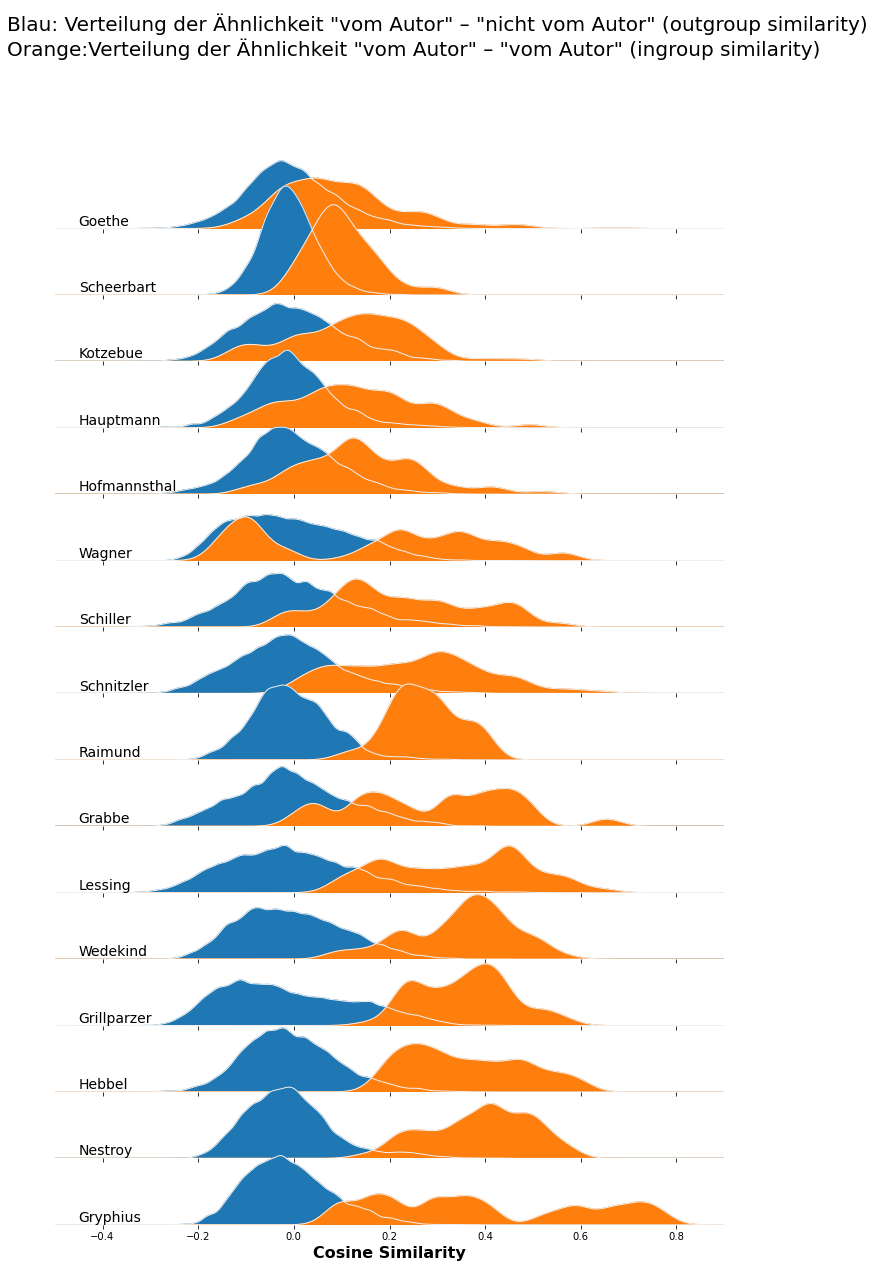

In [196]:
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity

plot_authors = list(pairwise_ingroup_distances.keys())
plot_authors = sorted(plot_authors, key=lambda a: np.array(pairwise_ingroup_distances[a]).mean())

gs = grid_spec.GridSpec(len(plot_authors),1)
fig = plt.figure(figsize=(12,len(plot_authors)*1.4))

i = 0

ax_objs = []
for author in plot_authors:
        
    ingroup_distances = pairwise_ingroup_distances[author]
    outgroup_distances = pairwise_outgroup_distances[author]
    
    
    x_d = np.linspace(-1,1, 1000)
        
    #outgroup dist
    x = np.array(outgroup_distances)

    kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color='tab:blue')
    
    #ingroup dist
    x = np.array(ingroup_distances)

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color='tab:orange')


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.5,0.9)
    ax_objs[-1].set_ylim(0,15)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])
    
    
    if i < len(plot_authors)-1:
        ax_objs[-1].set_xticklabels([])
    else:
        ax_objs[-1].set_xlabel("Cosine Similarity", fontsize=16,fontweight="bold")

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.45,0.2,author,fontsize=14,ha="left")
    i += 1

gs.update(hspace=-0.7)
fig.text(0.07,0.85,'Blau: Verteilung der Ähnlichkeit "vom Autor" – "nicht vom Autor" (outgroup similarity)\nOrange:Verteilung der Ähnlichkeit "vom Autor" – "vom Autor" (ingroup similarity)',fontsize=20)
plt.show()